CNN -> 데이터 전처리 -> CNN으로 이미지 분류 -> 전이학습 모델 VGG 분류

In [1]:
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

In [2]:
train_data = CIFAR10(
    root='./', train=True, download=True, transform=ToTensor()
)
test_data = CIFAR10(
    root='./', train=False, download=True, transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:04<00:00, 39365054.81it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
train_data.data[0].shape

(32, 32, 3)

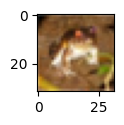

In [5]:
plt.figure(figsize=(1,1))
plt.imshow(train_data.data[0])

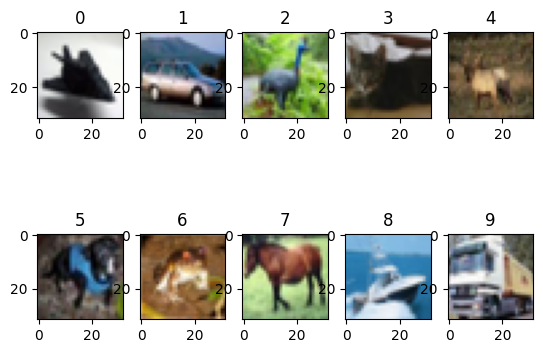

In [10]:
import numpy as np
class_index = [np.where(np.array(train_data.targets)==i)[0][0] for i in range(10)]
for i, idx in enumerate(class_index):
  plt.subplot(2,5,i+1)
  plt.imshow(train_data.data[idx])
  plt.title(i)
plt.show()

In [11]:
train_data.data.shape

(50000, 32, 32, 3)

데이터 증강
- 데이터가 부족하거나 오버피팅을 피하는 기법

In [2]:
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

100%|██████████| 170498071/170498071 [00:04<00:00, 35971419.53it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


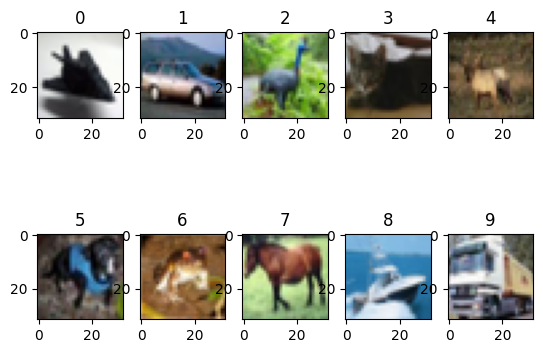

In [3]:
transforms = Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.5,0.5,0.5),std=(0.2,0.2,0.2))
])
train_data = CIFAR10(
    root='./', train=True, download=True, transform=ToTensor()
)
test_data = CIFAR10(
    root='./', train=False, download=True, transform=ToTensor()
)

import numpy as np
class_index = [np.where(np.array(train_data.targets)==i)[0][0] for i in range(10)]
for i, idx in enumerate(class_index):
  plt.subplot(2,5,i+1)
  plt.imshow(train_data.data[idx])
  plt.title(i)
plt.show()

In [4]:
train_data.data.shape

(50000, 32, 32, 3)

데이터 정규화 수치 얻는 방법

In [12]:
import torch
train_data = CIFAR10(
    root = './', train=True, download=True, transform=ToTensor()
)
imgs = [item[0] for item in train_data]

Files already downloaded and verified


In [13]:
imgs = torch.stack(imgs, dim=0).numpy()
imgs.shape

(50000, 3, 32, 32)

In [14]:
r_mean = imgs[:,0,:,:].mean()
g_mean = imgs[:,1,:,:].mean()
b_mean = imgs[:,2,:,:].mean()
print(r_mean, g_mean, b_mean)

r_std = imgs[:,0,:,:].std()
g_std = imgs[:,1,:,:].std()
b_std = imgs[:,2,:,:].std()
print(r_std, g_std, b_std)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


CNN으로 이미지 분류

In [16]:
import torch.nn as nn

class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels, hidden_dim, kernel_size=3, padding=1
    )
    self.conv1 = nn.Conv2d(
        hidden_dim, out_channels, kernel_size=3, padding=1
    )
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    output = self.pool(x)
    return output


VGG 모델 정의

In [19]:
class CNN(nn.Module):
  def __init__(self, num_class):
    super(CNN, self).__init__()
    self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
    self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
    self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

    self.fc1 = nn.Linear(in_features=256, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_class)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim=1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    output = self.fc3(x)

    return output

In [20]:
model = CNN(10)